Mise en place du seed et des differents package qui seront utiliser

In [12]:
set.seed(123)

In [ ]:
install.packages("caret")
install.packages("tidyverse")
install.packages("corrplot")
install.packages("rpart")
install.packages("rpart.plot")
install.packages("matrixStats")
install.packages("MLmetrics")

In [ ]:
library(caret)
library(tidyverse)
library(corrplot)
library(rpart)
library(rpart.plot)
library(matrixStats)
library(MLmetrics)

Chargement des different datasets et premier apercu des données

In [15]:
train <- read.csv("Richters_Predictor_Modeling_Earthquake_Damage_-_Train_Values.csv")
label <- read.csv("Richters_Predictor_Modeling_Earthquake_Damage_-_Train_Labels.csv")
test <- read.csv("Richters_Predictor_Modeling_Earthquake_Damage_-_Test_Values.csv")
trainMerged <- inner_join(train, label, by='building_id')
dim(train)
dim(label)
dim(test)
dim(trainMerged)

[1] 260601     39

[1] 260601      2

[1] 86868    39

[1] 260601     40

Les dimension sont en concordance avec celle enoncer sur le site DivenData

In [ ]:
head(train)
head(label)

Ici l'objectif est de tenter de reduire l'impact des valeurs extrême de certaines varialbes. Par exemple la variable age contient certaine valeurs très elever (batiment qui ont presque 1000 ans), afin d'eviter que cela impact la precision de nos tâches Nous allons les reduires en les remplacant par des valeurs lmimite (Winsorization)

Count_floors_pre_eq

In [45]:
iqr <- IQR(trainMerged$count_floors_pre_eq)
factor <- 3
upper_limit <- median(trainMerged$count_floors_pre_eq) + factor * iqr
trainMerged$count_floors_pre_eq[trainMerged$count_floors_pre_eq > upper_limit] <- upper_limit

iqr <- IQR(test$count_floors_pre_eq)
factor <- 3
upper_limit <- median(test$count_floors_pre_eq) + factor * iqr
test$count_floors_pre_eq[test$count_floors_pre_eq > upper_limit] <- upper_limit


     1      2 
 40441 220160 

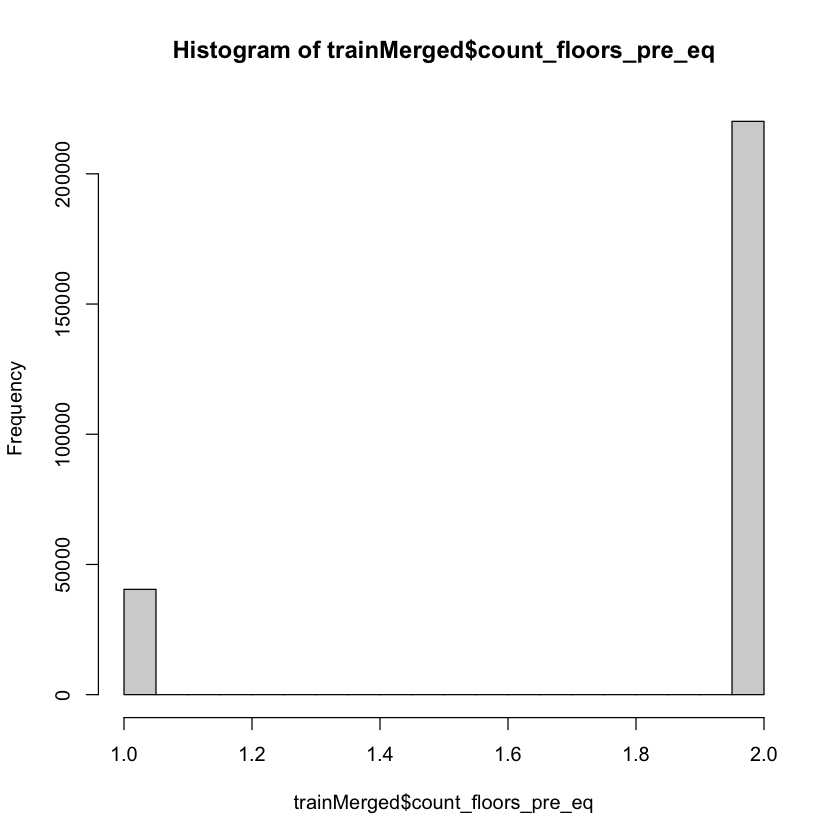

In [6]:
hist(trainMerged$count_floors_pre_eq)
table(trainMerged$count_floors_pre_eq)

Age

In [46]:
iqr <- IQR(trainMerged$age)
factor <- 3
upper_limit <- median(trainMerged$age) + factor * iqr
trainMerged$age[trainMerged$age > upper_limit] <- upper_limit

iqr <- IQR(test$age)
factor <- 3
upper_limit <- median(test$age) + factor * iqr
test$age[test$age > upper_limit] <- upper_limit

In [ ]:
hist(trainMerged$age)
table(trainMerged$age)


Area_percentage

In [47]:
iqr <- IQR(trainMerged$area_percentage)
factor <- 3
upper_limit <- median(trainMerged$area_percentage) + factor * iqr
trainMerged$area_percentage[trainMerged$area_percentage > upper_limit] <- upper_limit

iqr <- IQR(test$area_percentage)
factor <- 3
upper_limit <- median(test$area_percentage) + factor * iqr
test$area_percentage[test$area_percentage > upper_limit] <- upper_limit

In [ ]:
hist(trainMerged$area_percentage)
table(trainMerged$area_percentage)

Height_percentage

In [48]:
iqr <- IQR(trainMerged$height_percentage)
factor <- 1.5
upper_limit <- median(trainMerged$height_percentage) + factor * iqr
trainMerged$height_percentage[trainMerged$height_percentage > upper_limit] <- upper_limit

iqr <- IQR(test$height_percentage)
factor <- 1.5
upper_limit <- median(test$height_percentage) + factor * iqr
test$height_percentage[test$height_percentage > upper_limit] <- upper_limit

In [ ]:
hist(trainMerged$height_percentage)
table(trainMerged$height_percentage)

Count_families

In [49]:
iqr <- IQR(trainMerged$count_families)
factor <- 1.5
upper_limit <- median(trainMerged$count_families) + factor * iqr
trainMerged$count_families[trainMerged$count_families > upper_limit] <- upper_limit

iqr <- IQR(test$count_families)
factor <- 1.5
upper_limit <- median(test$count_families) + factor * iqr
test$count_families[test$count_families > upper_limit] <- upper_limit

In [ ]:
hist(trainMerged$count_families)
table(trainMerged$count_families)

On regarde si on a pas de NAN

In [ ]:
summary(train)
summary(label)
summary(test)

Bonne nouvelle aucune msiing values sont presentent

(A voir si on garde ou pas) On met en place encore quelque graph afin d'avoir une premiere idée sur nos variable

In [ ]:
bar_plot_stats <- function(data1, data2, name) {
    T1 <- table(data1, data2)
    Prop1 <- T1/rowSums(T1)
    barplot(t(Prop1), horiz=TRUE, col=rainbow(3), main=name, las=1, cex.names = 0.6)
}

In [ ]:
for (i in colnames(trainMerged[5:39])) {
    bar_plot_stats(trainMerged[, i], trainMerged$damage_grade, i)
}

Un certain nombre de variable sont categorielle cela risque d'êtres mauvais pour les etape suivante du projet donc noux allons utilser le one hot encoding afin de les rendre numerique 

Etape 1 : on detecte les variable a modifier 

In [50]:
character_variables_bool<-sapply(trainMerged[1,],class)=="character"
character_variables_boolT<-sapply(test[1,],class)=="character"
character_variables_bool

building_id                         geo_level_1_id 
                                 FALSE                                  FALSE 
                        geo_level_2_id                         geo_level_3_id 
                                 FALSE                                  FALSE 
                   count_floors_pre_eq                                    age 
                                 FALSE                                  FALSE 
                       area_percentage                      height_percentage 
                                 FALSE                                  FALSE 
                land_surface_condition                        foundation_type 
                                  TRUE                                   TRUE 
                             roof_type                      ground_floor_type 
                                  TRUE                                   TRUE 
                      other_floor_type                               position 
                                  TRUE                                   TRUE 
                    plan_configuration           has_superstructure_adobe_mud 
                                  TRUE                                  FALSE 
   has_superstructure_mud_mortar_stone          has_superstructure_stone_flag 
                                 FALSE                                  FALSE 
has_superstructure_cement_mortar_stone    has_superstructure_mud_mortar_brick 
                                 FALSE                                  FALSE 
has_superstructure_cement_mortar_brick              has_superstructure_timber 
                                 FALSE                                  FALSE 
             has_superstructure_bamboo   has_superstructure_rc_non_engineered 
                                 FALSE                                  FALSE 
      has_superstructure_rc_engineered               has_superstructure_other 
                                 FALSE                                  FALSE 
                legal_ownership_status                         count_families 
                                  TRUE                                  FALSE 
                     has_secondary_use          has_secondary_use_agriculture 
                                 FALSE                                  FALSE 
               has_secondary_use_hotel               has_secondary_use_rental 
                                 FALSE                                  FALSE 
         has_secondary_use_institution               has_secondary_use_school 
                                 FALSE                                  FALSE 
            has_secondary_use_industry          has_secondary_use_health_post 
                                 FALSE                                  FALSE 
          has_secondary_use_gov_office           has_secondary_use_use_police 
                                 FALSE                                  FALSE 
               has_secondary_use_other                           damage_grade 
                                 FALSE                                  FALSE

In [51]:
character_variables <- which(sapply(trainMerged[1,],class)=="character")
character_variablesT <- which(sapply(test[1,],class)=="character")
character_variables
length(character_variables)

land_surface_condition        foundation_type              roof_type 
                     9                     10                     11 
     ground_floor_type       other_floor_type               position 
                    12                     13                     14 
    plan_configuration legal_ownership_status 
                    15                     27

[1] 8

In [52]:
data_preprocessed<-trainMerged[,-character_variables]
data_preprocessedT<-test[,-character_variablesT]
dim(data_preprocessed)


[1] 260601     32

In [24]:
head(data_preprocessed)

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,802906,6,487,12198,2,30,6,5,1,1,...,0,0,0,0,0,0,0,0,0,3
2,28830,8,900,2812,2,10,8,7,0,1,...,0,0,0,0,0,0,0,0,0,2
3,94947,21,363,8973,2,10,5,5,0,1,...,0,0,0,0,0,0,0,0,0,3
4,590882,22,418,10694,2,10,6,5,0,1,...,0,0,0,0,0,0,0,0,0,2
5,201944,11,131,1488,2,30,8,8,1,0,...,0,0,0,0,0,0,0,0,0,3
6,333020,8,558,6089,2,10,9,5,0,1,...,0,0,0,0,0,0,0,0,0,2


In [53]:
data_normalise <- scale(data_preprocessed[, c("geo_level_1_id", "geo_level_2_id", "geo_level_3_id" )])
data_normaliseT <- scale(data_preprocessedT[, c("geo_level_1_id", "geo_level_2_id", "geo_level_3_id" )])


In [54]:
data_preprocessed[, c("geo_level_1_id", "geo_level_2_id", "geo_level_3_id")] <- data_normalise[, c("geo_level_1_id", "geo_level_2_id", "geo_level_3_id" )]
data_preprocessedT[, c("geo_level_1_id", "geo_level_2_id", "geo_level_3_id")] <- data_normaliseT[, c("geo_level_1_id", "geo_level_2_id", "geo_level_3_id" )]

In [17]:
head(data_preprocessed)

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,802906,-0.9834118,-0.5187039,1.6290515,2,30,6,5,1,1,...,0,0,0,0,0,0,0,0,0,3
2,28830,-0.7344579,0.4819970,-0.9450156,2,10,8,7,0,1,...,0,0,0,0,0,0,0,0,0,2
3,94947,0.8837423,-0.8191565,0.7446102,2,10,5,5,0,1,...,0,0,0,0,0,0,0,0,0,3
4,590882,1.0082192,-0.6858913,1.2165864,2,10,6,5,0,1,...,0,0,0,0,0,0,0,0,0,2
5,201944,-0.3610271,-1.3812936,-1.3081165,2,30,8,8,1,0,...,0,0,0,0,0,0,0,0,0,3
6,333020,-0.7344579,-0.3466706,-0.0463135,2,10,9,5,0,1,...,0,0,0,0,0,0,0,0,0,2


In [ ]:
# Remplacer les valeurs nulles ou négatives par une valeur minimale positive
data_preprocessed$age[data_preprocessed$age <= 0] <- 0.1

# Appliquer la transformation logarithmique
data_preprocessed$age <- log(data_preprocessed$age)

# Afficher les premières lignes du dataframe pour vérifier les résultats
head(data_preprocessed)

Etape 2 : On applique le one hot encoding pour ces variables

In [27]:
cols_to_transform <- c("land_surface_condition", "foundation_type", "roof_type",
                       "ground_floor_type", "other_floor_type", "position", 
                       "plan_configuration", "legal_ownership_status")

one_hot_trans <- dummyVars(formula = ~ ., data = trainMerged[, cols_to_transform])

data_one_hot <- data.frame(predict(one_hot_trans, newdata = trainMerged))

In [55]:
cols_to_transformT <- c("land_surface_condition", "foundation_type", "roof_type",
                       "ground_floor_type", "other_floor_type", "position", 
                       "plan_configuration", "legal_ownership_status")

one_hot_transT <- dummyVars(formula = ~ ., data = test[, cols_to_transformT])

data_one_hotT <- data.frame(predict(one_hot_transT, newdata = test))

Etape 3 : On fusionne nos varibale modifer avec notre dataset afin d'obtenir un table avec seulement des valeur numeriques

In [68]:
trainCleaned <- cbind(data_preprocessed, data_one_hot)
trainCleanedT <- cbind(data_preprocessedT, data_one_hotT)
head(trainCleaned)


,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,...,plan_configurationm,plan_configurationn,plan_configurationo,plan_configurationq,plan_configurations,plan_configurationu,legal_ownership_statusa,legal_ownership_statusr,legal_ownership_statusv,legal_ownership_statusw
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,802906,-0.9834118,-0.5187039,1.6290515,2,30,6,5,1,1,...,0,0,0,0,0,0,0,0,1,0
2,28830,-0.7344579,0.4819970,-0.9450156,2,10,8,7,0,1,...,0,0,0,0,0,0,0,0,1,0
3,94947,0.8837423,-0.8191565,0.7446102,2,10,5,5,0,1,...,0,0,0,0,0,0,0,0,1,0
4,590882,1.0082192,-0.6858913,1.2165864,2,10,6,5,0,1,...,0,0,0,0,0,0,0,0,1,0
5,201944,-0.3610271,-1.3812936,-1.3081165,2,30,8,8,1,0,...,0,0,0,0,0,0,0,0,1,0
6,333020,-0.7344579,-0.3466706,-0.0463135,2,10,9,5,0,1,...,0,0,0,0,0,0,0,0,1,0


On rerire aussi la varibles building_id qui n'apportera rien durant les étape qui vont suivre

In [65]:
trainCleaned <- trainCleaned %>% relocate(damage_grade, .after = legal_ownership_statusw)
trainCleaned <- select(trainCleaned, -c(building_id))
trainCleanedT <- select(trainCleanedT, -c(building_id))
head(trainCleanedT)

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,...,plan_configurationm,plan_configurationn,plan_configurationo,plan_configurationq,plan_configurations,plan_configurationu,legal_ownership_statusa,legal_ownership_statusr,legal_ownership_statusv,legal_ownership_statusw
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.3875425,-0.2615809,1.3827458,2,20,7,6,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2,-0.9823929,-1.3623056,1.5691129,2,25,13,5,0,1,0,...,0,0,0,0,0,0,0,0,1,0
3,1.0102404,-1.6574450,1.0365963,2,5,4,5,0,1,0,...,0,0,0,0,0,0,0,0,1,0
4,1.5083988,-1.6090615,-1.5426699,1,0,19,3,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5,0.3875425,-1.0042677,0.4681765,2,15,8,7,0,1,0,...,0,0,0,0,0,0,0,0,1,0
6,1.0102404,-1.2921495,-0.6119306,1,55,4,3,0,1,0,...,0,0,0,0,0,0,0,0,1,0


Afin da'voir une premiere vision des correlation entre les varaible nous mettons en place une matrice de correlation 

In [30]:
numeric_data = c()
for (i in 1:ncol(trainCleaned)) {
    if (class(trainCleaned[, i]) != "character") {
        numeric_data <- append(numeric_data, i)
    }
}
cormat <- abs(cor(trainCleaned[, numeric_data]))
cormat

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,...,plan_configurationn,plan_configurationo,plan_configurationq,plan_configurations,plan_configurationu,legal_ownership_statusa,legal_ownership_statusr,legal_ownership_statusv,legal_ownership_statusw,damage_grade
geo_level_1_id,1.0000000000,0.0614048534,0.0027184451,0.1109811320,0.047254857,0.066744160,0.0749745389,0.018245465,0.152037764,0.0076772072,...,8.222888e-04,0.0081792905,0.0093826688,0.0085588975,0.0330521678,0.1003929898,0.0078735782,0.0820548764,0.0046460055,0.072346634
geo_level_2_id,0.0614048534,1.0000000000,0.0009210931,0.0410805603,0.031531869,0.039899529,0.0385702127,0.015832855,0.076491325,0.0087428232,...,4.151702e-04,0.0057857317,0.0043257875,0.0059284248,0.0255317097,0.0258932511,0.0270114837,0.0231892461,0.0135791615,0.043160757
geo_level_3_id,0.0027184451,0.0009210931,1.0000000000,0.0084718933,0.006303267,0.004083808,0.0185617772,0.015732164,0.026294351,0.0195789298,...,3.123084e-03,0.0028035078,0.0018949999,0.0033985366,0.0032398945,0.0341990799,0.0013094153,0.0185331138,0.0130999509,0.007931779
count_floors_pre_eq,0.1109811320,0.0410805603,0.0084718933,1.0000000000,0.173843296,0.050425836,0.6277704778,0.068826552,0.204379130,0.0085311469,...,7.872794e-04,0.0048608371,0.0497166509,0.0027085921,0.0301012707,0.0972693393,0.0250799492,0.0797932308,0.0079277459,0.137381378
age,0.0472548568,0.0315318687,0.0063032673,0.1738432963,1.000000000,0.028199789,0.2078606518,0.205273547,0.035490258,0.0107234241,...,2.344991e-03,0.0003816959,0.0148621917,0.0052148631,0.0128945102,0.0850105671,0.0001595599,0.0569515747,0.0144714096,0.153339609
area_percentage,0.0667441604,0.0398995295,0.0040838083,0.0504258362,0.028199789,1.000000000,0.1953243490,0.033860475,0.227149949,0.0011090877,...,2.579424e-03,0.0260175307,0.0166290177,0.0201812988,0.0992829378,0.0313130099,0.0186556730,0.0325607629,0.0024607117,0.128231354
height_percentage,0.0749745389,0.0385702127,0.0185617772,0.6277704778,0.207860652,0.195324349,1.0000000000,0.157218496,0.035731909,0.0183844591,...,1.665183e-03,0.0033387299,0.0219589151,0.0003233412,0.0005518607,0.0889136194,0.0124799573,0.0715128724,0.0021523050,0.085304688
has_superstructure_adobe_mud,0.0182454652,0.0158328554,0.0157321636,0.0688265517,0.205273547,0.033860475,0.1572184959,1.000000000,0.306861168,0.0069617504,...,1.530135e-03,0.0027853664,0.0173120256,0.0053125257,0.0190196841,0.0301759065,0.0251080746,0.0046808661,0.0331649780,0.055313602
has_superstructure_mud_mortar_stone,0.1520377636,0.0764913251,0.0262943509,0.2043791305,0.035490258,0.227149949,0.0357319091,0.306861168,1.000000000,0.0340455999,...,3.467759e-05,0.0208515104,0.0509111924,0.0174759834,0.0985564267,0.1387459777,0.0478715860,0.1266407426,0.0037261188,0.291325239
has_superstructure_stone_flag,0.0076772072,0.0087428232,0.0195789298,0.0085311469,0.010723424,0.001109088,0.0183844591,0.006961750,0.034045600,1.0000000000,...,5.316792e-04,0.0055826154,0.0117625293,0.0035426230,0.0095558954,0.0083835268,0.0049394746,0.0055453273,0.0052446171,0.066039449


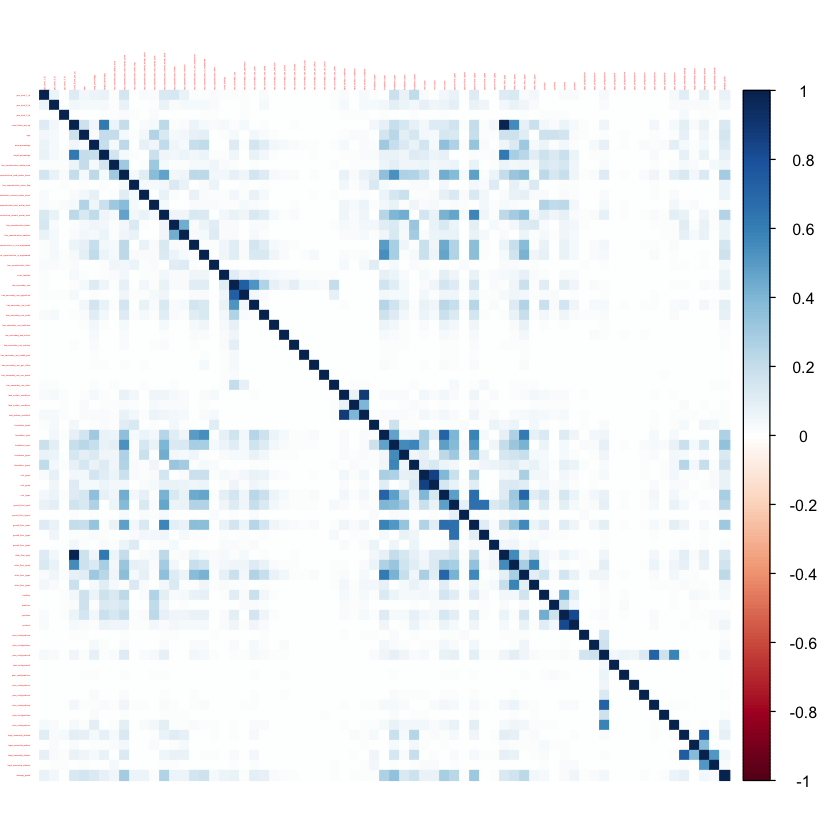

In [22]:
cormat <- abs(cor(trainCleaned))
corrplot(cormat, tl.cex = 0.1, method = "color")


In [31]:
to_delete_DG = c()
for (i in 1:(nrow(cormat)-1)) {
    for (j in i:(nrow(cormat)-1)) {
        if (cormat[i,j] > 0.5 &  i!=j) {
            if (abs(cormat[i,69]) < abs(cormat[j,69])) {
                to_delete_DG <- c(to_delete_DG, i)
            } else {
                to_delete_DG <- c(to_delete_DG, j)
            }
        }
    }
}
to_delete_DG <- to_delete_DG[!duplicated(to_delete_DG)]

to_delete_DG


[1]  7 47  4  9 13 17 21 20 31 35 49 37 38 44 40 41 42 45 50 53 62 57 67 68

In [ ]:
for (i in 1:(nrow(cormat)-1)) {
    if (cormat[i, 68] < 0.01) {
        to_delete_DG <- c(to_delete_DG, i)
    }
}
to_delete_DG <- to_delete_DG[!duplicated(to_delete_DG)]
to_delete_DG


In [33]:
trainCleanedD <- select(trainCleaned,-c(to_delete_DG))
head(trainCleanedD)

,geo_level_1_id,geo_level_2_id,geo_level_3_id,age,area_percentage,has_superstructure_adobe_mud,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_timber,...,plan_configurationc,plan_configurationf,plan_configurationm,plan_configurationn,plan_configurationo,plan_configurations,plan_configurationu,legal_ownership_statusa,legal_ownership_statusr,damage_grade
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,-0.9834118,-0.5187039,1.6290515,30,6,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
2,-0.7344579,0.4819970,-0.9450156,10,8,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3,0.8837423,-0.8191565,0.7446102,10,5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
4,1.0082192,-0.6858913,1.2165864,10,6,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,2
5,-0.3610271,-1.3812936,-1.3081165,30,8,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
6,-0.7344579,-0.3466706,-0.0463135,10,9,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


Input and output varaibles 

In [34]:
X<-trainCleanedD[,setdiff(colnames(trainCleanedD),"damage_grade")]
Y<-trainCleanedD[,"damage_grade"]
N <-nrow(X)
n <-ncol(X)

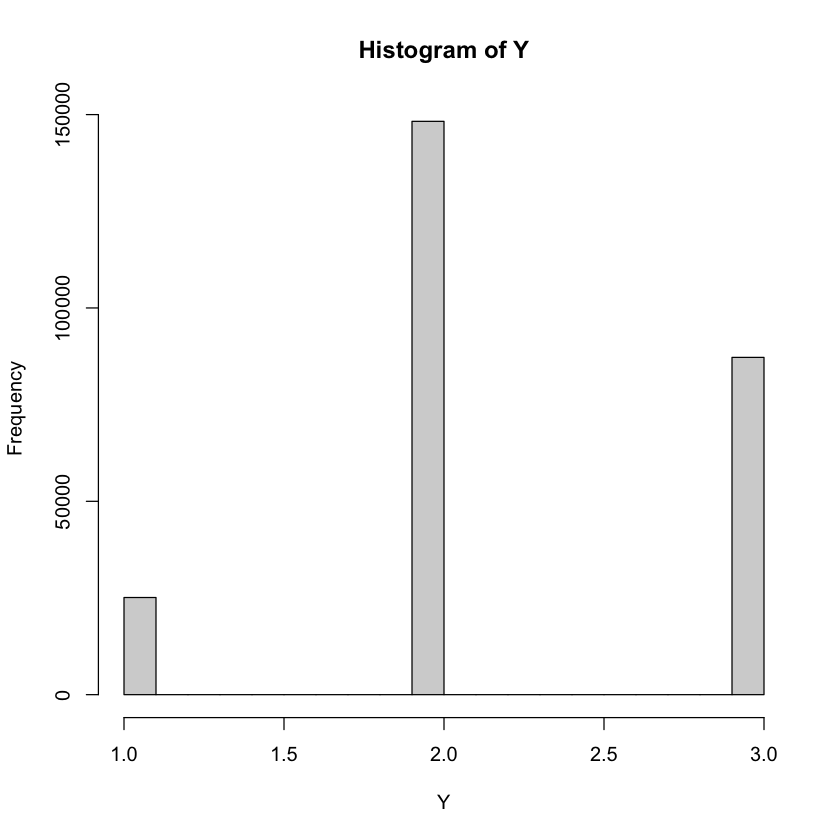

In [35]:
hist(Y)

In [ ]:
# drop = F is used to preserve the structure of the data as data.frame (see https://www.r-bloggers.com/2018/02/r-tip-use-drop-false-with-data-frames/)
CV_folds <- 10

size_CV <-floor(N/CV_folds)

CV_err<-matrix(0,nrow=n,ncol=CV_folds)

for (i in 1:CV_folds) {
    
    idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
    X_ts<-X[idx_ts,]  
    Y_ts<-Y[idx_ts]  
     
    idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
    X_tr<-X[idx_tr,]
    Y_tr<-Y[idx_tr]                          
    
    # Compute correlation across all the input variables and the target variable
    correlation_vector <-abs(cor(X_tr,Y_tr))
    # Rank variables according to correlation with the output
    correlation_ranking_idx <-sort(correlation_vector,dec=T,index.return=T)$ix
     
    for (nb_features in 1:n) {
        # Create a dataset including only the nb_features most correlated variables with the output
        DS<-cbind(X_tr[,correlation_ranking_idx[1:nb_features],drop=F],damage_grade=Y_tr)
        
        # Model fit (using lm function)
        model<- lm(damage_grade~.,DS)
        
        # Model prediction
        Y_hat_ts<- predict(model,X_ts[,correlation_ranking_idx[1:nb_features],drop=F])
        
        # Cross validation error = MSE
        CV_err[nb_features,i] <- mean((Y_hat_ts-Y_ts)^2)
    }
}  

print(paste("#Features: ",c(1:n)," ; CV error=",round(apply(CV_err,1,mean),digits=4), " ; std dev=",round(apply(CV_err,1,sd),digits=4)))

In [ ]:
NuF1 <- correlation_ranking_idx
NaF1 <- colnames(X)[correlation_ranking_idx]
NuF1
NaF1

In [36]:
# drop = F is used to preserve the structure of the data as data.frame (see https://www.r-bloggers.com/2018/02/r-tip-use-drop-false-with-data-frames/)

CV_folds <- 10

size_CV <-floor(N/CV_folds)

CV_err<-matrix(0,nrow=n,ncol=CV_folds)

for (i in 1:CV_folds) {
    
    idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
    X_ts<-X[idx_ts,]  
    Y_ts<-Y[idx_ts]  
     
    idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
    X_tr<-X[idx_tr,]
    Y_tr<-Y[idx_tr]                          
    
    # Computing the correlation between input variables and output variable on the training set
    correlation<-abs(cor(X_tr,Y_tr))
    
    # Initialization : No variables are selected and all the variables are candidates
    selected<-c()
    candidates<-1:n
    
    #mRMR ranks the variables by taking account not only the correlation with the output, but also by avoiding redudant variables
    for (j in 1:n) {
        redundancy_score<-numeric(length(candidates))
        
        if (length(selected)>0) {
            # Compute the correlation between the selected variables and the candidates on the training set
            cor_selected_candidates<-cor(X_tr[,selected,drop=F],X_tr[,candidates,drop=F])
            # Compute the mean correlation for each candidate variable, across the selected variables
            redundancy_score<-apply(cor_selected_candidates,2,mean)
        }
        
        # mRMR: minimum Redundancy Maximum Relevancy
        mRMR_score<-correlation[candidates]-redundancy_score
        
        # Select the candidate variable that maximises the mRMR score
        selected_current<-candidates[which.max(mRMR_score)]
        selected<-c(selected,selected_current)
        
        # Remove the selected variables from the candidates
        candidates<-setdiff(candidates,selected_current)
    }
    
    ranking <- selected
     
    for (nb_features in 1:n) {
        # Create a dataset including only the first nb_features selected variables
        DS<-cbind(X_tr[,ranking[1:nb_features],drop=F],damage_grade=Y_tr)
        
        # Model fit (using lm function)
        model<- lm(damage_grade~.,DS)
        
        # Model prediction
        Y_hat_ts<- predict(model,X_ts[,ranking[1:nb_features],drop=F])
        
        # Cross-validation error = MSE
        CV_err[nb_features,i]<-mean((Y_hat_ts-Y_ts)^2)
    }
}  

print(paste("#Features: ",c(1:n)," ; CV error=",round(apply(CV_err,1,mean),digits=4), " ; std dev=",round(apply(CV_err,1,sd),digits=4)))

 [1] "#Features:  1  ; CV error= 0.3302  ; std dev= 0.0022" 
 [2] "#Features:  2  ; CV error= 0.3288  ; std dev= 0.002"  
 [3] "#Features:  3  ; CV error= 0.3286  ; std dev= 0.002"  
 [4] "#Features:  4  ; CV error= 0.3276  ; std dev= 0.002"  
 [5] "#Features:  5  ; CV error= 0.3266  ; std dev= 0.002"  
 [6] "#Features:  6  ; CV error= 0.3249  ; std dev= 0.002"  
 [7] "#Features:  7  ; CV error= 0.3249  ; std dev= 0.002"  
 [8] "#Features:  8  ; CV error= 0.3246  ; std dev= 0.002"  
 [9] "#Features:  9  ; CV error= 0.3245  ; std dev= 0.0019" 
[10] "#Features:  10  ; CV error= 0.324  ; std dev= 0.0019" 
[11] "#Features:  11  ; CV error= 0.3235  ; std dev= 0.0018"
[12] "#Features:  12  ; CV error= 0.3229  ; std dev= 0.0018"
[13] "#Features:  13  ; CV error= 0.3216  ; std dev= 0.0021"
[14] "#Features:  14  ; CV error= 0.3211  ; std dev= 0.0016"
[15] "#Features:  15  ; CV error= 0.3208  ; std dev= 0.0018"
[16] "#Features:  16  ; CV error= 0.3198  ; std dev= 0.0019"
[17] "#Features:  17  ; 

In [37]:
NuF2 <- selected
NaF2 <- colnames(X)[selected]
NuF2
NaF2

[1] 27 12 43 31  5  4  1 15 28 16 10 14  7 42  8 34  2 11 17  6 36 25 24 35 23
[26] 29 30 13 32 40 19 18 21 41 20 26  3 38 39 44 22 37 33  9

[1] "foundation_typer"                      
 [2] "has_superstructure_rc_non_engineered"  
 [3] "legal_ownership_statusa"               
 [4] "other_floor_typeq"                     
 [5] "area_percentage"                       
 [6] "age"                                   
 [7] "geo_level_1_id"                        
 [8] "has_secondary_use_hotel"               
 [9] "roof_typen"                            
[10] "has_secondary_use_rental"              
[11] "has_superstructure_timber"             
[12] "count_families"                        
[13] "has_superstructure_stone_flag"         
[14] "plan_configurationu"                   
[15] "has_superstructure_cement_mortar_stone"
[16] "positiont"                             
[17] "geo_level_2_id"                        
[18] "has_superstructure_bamboo"             
[19] "has_secondary_use_institution"         
[20] "has_superstructure_adobe_mud"          
[21] "plan_configurationc"                   
[22] "land_surface_conditiont"               
[23] "land_surface_conditiono"               
[24] "plan_configurationa"                   
[25] "has_secondary_use_other"               
[26] "ground_floor_typem"                    
[27] "ground_floor_typez"                    
[28] "has_superstructure_other"              
[29] "positionj"                             
[30] "plan_configurationo"                   
[31] "has_secondary_use_industry"            
[32] "has_secondary_use_school"              
[33] "has_secondary_use_gov_office"          
[34] "plan_configurations"                   
[35] "has_secondary_use_health_post"         
[36] "foundation_typeh"                      
[37] "geo_level_3_id"                        
[38] "plan_configurationm"                   
[39] "plan_configurationn"                   
[40] "legal_ownership_statusr"               
[41] "has_secondary_use_use_police"          
[42] "plan_configurationf"                   
[43] "positiono"                             
[44] "has_superstructure_mud_mortar_brick"

In [ ]:
# drop = F is used to preserve the structure of the data as data.frame (see https://www.r-bloggers.com/2018/02/r-tip-use-drop-false-with-data-frames/)
CV_folds <- 10

size_CV <-floor(N/CV_folds)

CV_err<-matrix(0,nrow=n,ncol=CV_folds)

# Compute PCA on the full input dataset X and return the dataset transformed in the space of principal components
X_pca<-data.frame(prcomp(X,retx=T)$x)

for (i in 1:CV_folds) {
    
    idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
    X_ts<-X_pca[idx_ts,]  
    Y_ts<-Y[idx_ts]  
     
    idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
    X_tr<-X_pca[idx_tr,]
    Y_tr<-Y[idx_tr]         
     
    for (nb_components in 1:n) {
        # Create a dataset including only the first nb_components principal components
        DS<-cbind(X_tr[,1:nb_components,drop=F],damage_grade=Y_tr)
        
        # Model fit (using lm function)
        model<- lm(damage_grade~.,DS)
        
        # Model predict
        Y_hat_ts<- predict(model,X_ts[,1:nb_components,drop=F])
        
        CV_err[nb_components,i]<-mean((Y_hat_ts-Y_ts)^2)
    }
}  

print(paste("#Features: ",c(1:n)," ; CV error=",round(apply(CV_err,1,mean),digits=4), " ; std dev=",round(apply(CV_err,1,sd),digits=4)))


In [38]:
NaF2 <- 32
selected_features <- ranking[1:NaF2] 

New_Train <- trainCleanedD[, selected_features, drop = FALSE]

# Ajoutez la variable cible si nécessaire
New_Train <- cbind(New_Train, damage_grade = Y)


In [39]:
head(New_Train)

,foundation_typer,has_superstructure_rc_non_engineered,legal_ownership_statusa,other_floor_typeq,area_percentage,age,geo_level_1_id,has_secondary_use_hotel,roof_typen,has_secondary_use_rental,...,plan_configurationa,has_secondary_use_other,ground_floor_typem,ground_floor_typez,has_superstructure_other,positionj,plan_configurationo,has_secondary_use_industry,has_secondary_use_school,damage_grade
,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<int>,...,<dbl>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<int>,<int>,<int>
1,1,0,0,1,6,30,-0.9834118,0,1,0,...,0,0,0,0,0,0,0,0,0,3
2,1,0,0,1,8,10,-0.7344579,0,1,0,...,0,0,0,0,0,0,0,0,0,2
3,1,0,0,0,5,10,0.8837423,0,1,0,...,0,0,0,0,0,0,0,0,0,3
4,1,0,0,0,6,10,1.0082192,0,1,0,...,0,0,0,0,0,0,0,0,0,2
5,1,0,0,0,8,30,-0.3610271,0,1,0,...,0,0,0,0,0,0,0,0,0,3
6,1,0,0,1,9,10,-0.7344579,0,1,0,...,0,0,0,0,0,0,0,0,0,2


In [ ]:
New_Train

In [ ]:
X<-New_Train[,setdiff(colnames(New_Train),"damage_grade")]
Y<-New_Train[,"damage_grade"]


N <-nrow(X)
n <-ncol(X)

Decison Tree

In [40]:
# from https://pastebin.com/b6WufBNq

ConfusionMatrix <- function(y_pred, y_true) {
  Confusion_Mat <- table(y_true, y_pred)
  return(Confusion_Mat)
}
 
ConfusionDF <- function(y_pred, y_true) {
  Confusion_DF <- transform(as.data.frame(ConfusionMatrix(y_pred, y_true)),
                            y_true = as.character(y_true),
                            y_pred = as.character(y_pred),
                            Freq = as.integer(Freq))
  return(Confusion_DF)
}
 
Precision_micro <- function(y_true, y_pred, labels = NULL) {
  Confusion_DF <- ConfusionDF(y_pred, y_true)
 
  if (is.null(labels) == TRUE) labels <- unique(c(y_true, y_pred))
  # this is not bulletproof since there might be labels missing (in strange cases)
  # in strange cases where they existed in training set but are missing from test ground truth and predictions.
 
  TP <- c()
  FP <- c()
  for (i in c(1:length(labels))) {
    positive <- labels[i]
   
    # it may happen that a label is never predicted (missing from y_pred) but exists in y_true
    # in this case ConfusionDF will not have these lines and thus the simplified code crashes
    # TP[i] <- as.integer(Confusion_DF[which(Confusion_DF$y_true==positive & Confusion_DF$y_pred==positive), "Freq"])
    # FP[i] <- as.integer(sum(Confusion_DF[which(Confusion_DF$y_true!=positive & Confusion_DF$y_pred==positive), "Freq"]))
   
    # workaround:
    # i don't want to change ConfusionDF since i don't know if the current behaviour is a feature or a bug.
    tmp <- Confusion_DF[which(Confusion_DF$y_true==positive & Confusion_DF$y_pred==positive), "Freq"]
    TP[i] <- if (length(tmp)==0) 0 else as.integer(tmp)
   
    tmp <- Confusion_DF[which(Confusion_DF$y_true!=positive & Confusion_DF$y_pred==positive), "Freq"]
    FP[i] <- if (length(tmp)==0) 0 else as.integer(sum(tmp))
  }
  Precision_micro <- sum(TP) / (sum(TP) + sum(FP))
  return(Precision_micro)
}
 
Recall_micro <- function(y_true, y_pred, labels = NULL) {
  Confusion_DF <- ConfusionDF(y_pred, y_true)
 
  if (is.null(labels) == TRUE) labels <- unique(c(y_true, y_pred))
  # this is not bulletproof since there might be labels missing (in strange cases)
  # in strange cases where they existed in training set but are missing from test ground truth and predictions.
 
  TP <- c()
  FN <- c()
  for (i in c(1:length(labels))) {
    positive <- labels[i]
   
    # short version, comment out due to bug or feature of Confusion_DF
    # TP[i] <- as.integer(Confusion_DF[which(Confusion_DF$y_true==positive & Confusion_DF$y_pred==positive), "Freq"])
    # FP[i] <- as.integer(sum(Confusion_DF[which(Confusion_DF$y_true==positive & Confusion_DF$y_pred!=positive), "Freq"]))
   
    # workaround:
    tmp <- Confusion_DF[which(Confusion_DF$y_true==positive & Confusion_DF$y_pred==positive), "Freq"]
    TP[i] <- if (length(tmp)==0) 0 else as.integer(tmp)
 
    tmp <- Confusion_DF[which(Confusion_DF$y_true==positive & Confusion_DF$y_pred!=positive), "Freq"]
    FN[i] <- if (length(tmp)==0) 0 else as.integer(sum(tmp))
  }
  Recall_micro <- sum(TP) / (sum(TP) + sum(FN))
  return(Recall_micro)
}
 
F1_Score_micro <- function(y_true, y_pred, labels = NULL) {
  if (is.null(labels) == TRUE) labels <- unique(c(y_true, y_pred)) # possible problems if labels are missing from y_*
  Precision <- Precision_micro(y_true, y_pred, labels)
  Recall <- Recall_micro(y_true, y_pred, labels)
  F1_Score_micro <- 2 * (Precision * Recall) / (Precision + Recall)
  return(F1_Score_micro)
}

Decision Tree

In [ ]:
shuffled_index <- sample(1:nrow(New_Train))

In [ ]:
half_index <- floor(nrow(New_Train)/2)

In [ ]:
train_data <-  New_Train[shuffled_index[1:half_index],]
test_data <-  New_Train[shuffled_index[(half_index+1):nrow(New_Train)],]

In [ ]:
print(paste("Training Set Size : ",half_index ,"Test set Size : ",nrow(New_Train)-half_index ))

In [ ]:
model <- rpart(damage_grade ~ . , method="class", data=train_data)

In [ ]:
data.frame(model$variable.importance)

In [ ]:
rpart.plot(model, type=1 , fallen.leaves = F ,cex =0.9)

In [ ]:
Y_pred_probs <- predict(model, test_data[,-ncol(test_data)], type = "prob")

In [ ]:
Y <- test_data[,ncol(test_data)]

In [ ]:
Y_pred <- ifelse(Y_pred_probs[,1] > 0.3, "1", 
            ifelse(Y_pred_probs[,2] > 0.5, "2", "3"))
confusion_matrix <- table(Y_pred, Y)

In [ ]:
Y_pred <- as.factor(Y_pred)
Y <- as.factor(Y)
f1_score <- F1_Score_micro(Y, Y_pred)
print(paste("F1 Score:", f1_score))
accuracy = sum(diag(confusion_matrix))/sum(confusion_matrix)
misclassification_rate = 1 - accuracy
print(paste("Misclassification_rate On Damage Grade Prediction = " , misclassification_rate))
print(paste( "Accuracy On Damage Grade Prediction = " , accuracy))

In [42]:
install.packages("randomForest")
library("randomForest")


Les packages binaires t'el'echarg'es sont dans
	/var/folders/7j/n3q0pxkj3fvc8pf6rq5cpq680000gn/T//RtmpdHQZPQ/downloaded_packages


randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.


Attachement du package : 'randomForest'


L'objet suivant est masqu'e depuis 'package:dplyr':

    combine


L'objet suivant est masqu'e depuis 'package:ggplot2':

    margin




In [ ]:
head(New_Train)

random forest


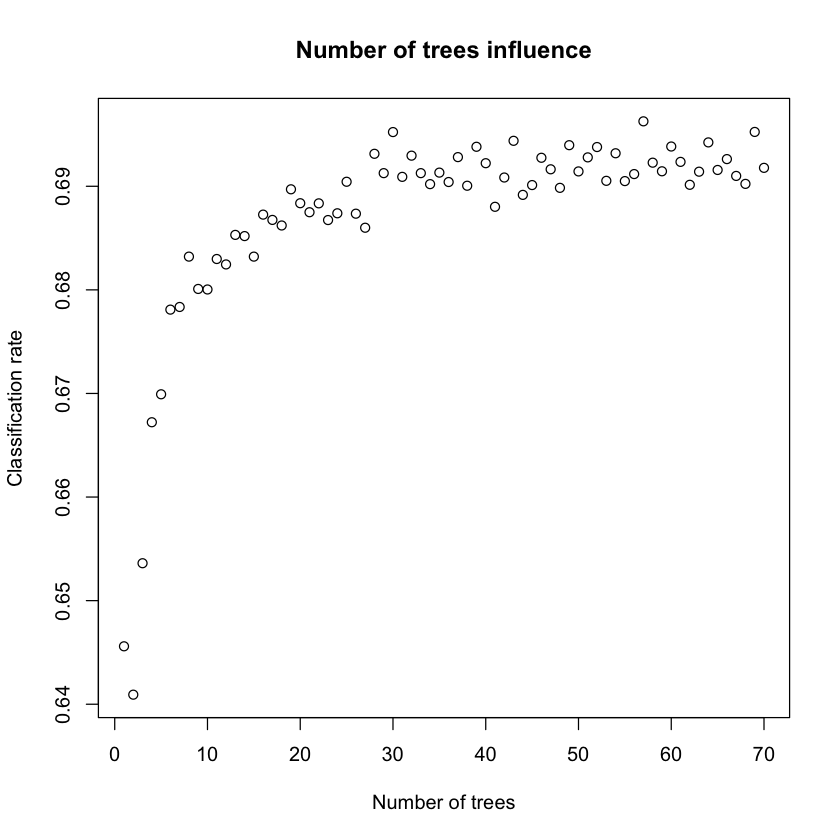

[1] "F1 Score: 0.691779332574411"


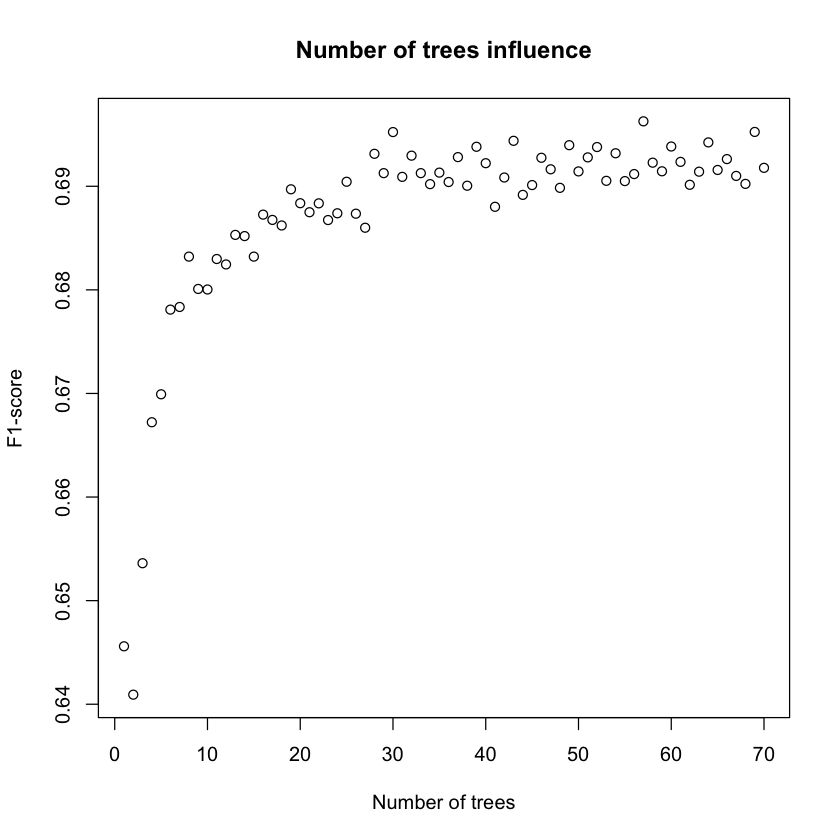

In [77]:
n_trees <- 70
accuracy_vec <- rep(0, n_trees)
f1_score_vec <- rep(0, n_trees)

class_weights <- table(New_Train$damage_grade) / nrow(New_Train)  # Calcul des poids de classe

for (i in 1:n_trees) {
  # Split the dataset into training and test sets
  train_data_idx <- sample(1:nrow(New_Train), floor(0.7 * nrow(New_Train)))
  train_data <- New_Train[train_data_idx, ]
  test_data <- New_Train[-train_data_idx, ]
  
  # Fit the random forest model
  model <- randomForest(
    x = train_data[, -which(names(train_data) == "damage_grade")],
    y = as.factor(train_data$damage_grade),
    ntree = i,
    classwt = class_weights  # Utilisation des poids de classe calculés
  )
  
  # Predict on the test set
  predictions <- predict(model, newdata = test_data[, -which(names(test_data) == "damage_grade")])
  
  # Calculate accuracy
  correct_predictions <- sum(predictions == test_data$damage_grade)
  accuracy <- correct_predictions / nrow(test_data)
  accuracy_vec[i] <- accuracy
  
  # Calculate F1-score
  f1_score <- F1_Score_micro(test_data$damage_grade, predictions)  # Adjust positive class label if needed
  f1_score_vec[i] <- f1_score
}

plot(accuracy_vec, main = "Number of trees influence", xlab = "Number of trees", ylab = "Classification rate")
plot(f1_score_vec, main = "Number of trees influence", xlab = "Number of trees", ylab = "F1-score")
print(paste("F1 Score:", f1_score))


In [ ]:
result_df  <- data.frame(building_id = test$building_id, damage_grade = predictions)
result_df

In [ ]:
predictions <- predict(model, newdata = trainCleanedT)
predictions

In [38]:
var_importance <- importance(model)
sort(var_importance, decreasing = TRUE)

[1] 7952.81053 4989.25860 2518.76582 2473.91864 2187.71443  823.43567
 [7]  589.52130  506.18681  494.91757  454.45970  438.89578  409.88955
[13]  370.88305  362.02932  308.36461  283.52814  280.78773  225.74328
[19]  223.69482  212.52375  203.85847  176.57627  131.75005   92.08684
[25]   71.31925   47.17757   28.12102   23.85101   19.60335   15.39033

In [71]:
write.csv(result_df, file = "result.csv", row.names = FALSE)

In [ ]:
install.packages("xgboost")
library(xgboost)

In [ ]:
# 1. Mélanger l'ensemble de données de manière aléatoire.
shuffled_index <- sample(1:nrow(New_Train))

# 2. Obtenir l'indice pour la moitié de l'ensemble de données
half_index <- floor(nrow(New_Train)/2)

# 3. Diviser les données d'entraînement en deux plus petits dataframes : l'ensemble d'entraînement et l'ensemble de test
train_data <- New_Train[shuffled_index[1:half_index], ]
test_data <- New_Train[shuffled_index[(half_index+1):nrow(New_Train)], ]

#4. Tailles de l'ensemble d'entraînement et de l'ensemble de test
print(paste("Training Set Size:", half_index, "Test Set Size:", nrow(New_Train)-half_index))

#5. Entraîner le modèle de gradient boosting tree (XGBoost)
model <- xgboost(data = as.matrix(train_data[, -ncol(train_data)]),
                 label = train_data[, ncol(train_data)],
                 nrounds = 10,
                 objective = "multi:softmax",
                 num_class = 4)

# Visualiser l'importance des variables
xgb.importance(feature_names = colnames(train_data[, -ncol(train_data)]), model = model)

# Obtenir les prédictions de notre ensemble de test à partir de notre modèle entraîné
Y_pred <- predict(model, as.matrix(test_data[, -ncol(test_data)]))

# Obtenir les résultats réels de l'ensemble de test
Y <- test_data[, ncol(test_data)]

# Matrice de confusion
confusion_matrix <- table(Y_pred, Y)

# Calculer le score F1
library(MLmetrics)
f1_score <- F1_Score_micro(Y, Y_pred)
print(paste("F1 Score:", f1_score))

accuracy <- sum(diag(confusion_matrix)) / sum(confusion_matrix)
misclassification_rate <- 1 - accuracy
print(paste("Misclassification Rate on Damage Grade Prediction:", misclassification_rate))
print(paste("Accuracy on Damage Grade Prediction:", accuracy))

